In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import os, sys

import sys
sys.path.append("./sngp/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)

from sngp.model import RFFGP_Reg
from sngp.loss import square_loss
from sngp.train import train_model

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

Using CPU
Final device: cpu


In [2]:
## GP MODEL 

class RBFKernel:
    def __init__(self, lengthscale=1.0, outputscale=1.0):
        self.lengthscale = lengthscale
        self.outputscale = outputscale
    
    def __call__(self, X1, X2):
        dist_sq = torch.cdist(X1, X2, p=2).pow(2)
        return self.outputscale**2 * torch.exp(-dist_sq / (2 * self.lengthscale**2))


class RBFKernelLearnable(nn.Module):
    """RBF kernel with learnable hyperparameters."""
    
    def __init__(self, lengthscale=1.0, outputscale=1.0):
        super().__init__()
        # Store as log-parameters for positivity constraint
        self.log_lengthscale = nn.Parameter(torch.tensor(lengthscale).log())
        self.log_outputscale = nn.Parameter(torch.tensor(outputscale).log())
    
    @property
    def lengthscale(self):
        return self.log_lengthscale.exp()
    
    @property
    def outputscale(self):
        return self.log_outputscale.exp()
    
    def forward(self, X1, X2):
        dist_sq = torch.cdist(X1, X2, p=2).pow(2)
        return self.outputscale**2 * torch.exp(-dist_sq / (2 * self.lengthscale**2))
    

class FullGP(nn.Module):
    """
    Full GP regression with explicit matrix inverse.
    
    Posterior formulas:
        μ* = K_X*X @ K̂_XX^{-1} @ y
        Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        
    where K̂_XX = K_XX + σ²I
    """
    
    def __init__(self, lengthscale=1.0, outputscale=1.0, noise=0.1, learn_hyperparams=False):
        if learn_hyperparams:
            self.kernel = RBFKernelLearnable(lengthscale, outputscale)
        else:
            self.kernel = RBFKernel(lengthscale, outputscale)
        self.noise = noise
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        N = len(X_train)
        
        # K_XX: kernel matrix between training points, shape (N, N)
        K_XX = self.kernel(X_train, X_train)
        
        # K̂_XX = K_XX + σ²I: noisy kernel matrix
        K_XX_noisy = K_XX + self.noise**2 * torch.eye(N)
        
        # Explicit inverse: K̂_XX^{-1}
        self.K_XX_noisy_inv = torch.linalg.inv(K_XX_noisy)

        
    def predict(self, X_test):
        """
        Full closed-form prediction.
        
        μ* = K_X*X @ K̂_XX^{-1} @ y
        Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        """
        # K_X*X: kernel between test and train, shape (M, N)
        K_X_star_X = self.kernel(X_test, self.X_train)
        
        # K_XX*: kernel between train and test, shape (N, M)
        K_X_X_star = self.kernel(self.X_train, X_test)
        
        # K_X*X*: kernel between test and test, shape (M, M)
        K_X_star_X_star = self.kernel(X_test, X_test)
        
        # =================================================================
        # POSTERIOR MEAN
        # μ* = K_X*X @ K̂_XX^{-1} @ y
        # =================================================================
        mean = K_X_star_X @ self.K_XX_noisy_inv @ self.y_train
        
        # =================================================================
        # POSTERIOR COVARIANCE (full matrix!)
        # Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        # =================================================================
        cov = K_X_star_X_star - K_X_star_X @ self.K_XX_noisy_inv @ K_X_X_star
        
        # Variance is diagonal of covariance
        var = torch.diag(cov)
        
        return mean, var, cov


class FullGPCholesky(nn.Module):
    """
    Full GP regression using Cholesky decomposition.
    
    Posterior formulas (mathematically equivalent to explicit inverse):
        μ* = K_X*X @ K̂_XX^{-1} @ y
        Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        
    where K̂_XX = K_XX + σ²I
    
    Implementation via Cholesky: K̂_XX = L L^T
        α = K̂_XX^{-1} @ y  (solved via L L^T α = y)
        μ* = K_X*X @ α
        v = L^{-1} @ K_XX*  (solved via L v = K_XX*)
        Σ* = K_X*X* - v^T @ v
    """
    
    def __init__(self, lengthscale=1.0, outputscale=1.0, noise=0.1, learn_hyperparams=False):
        super().__init__()
        if learn_hyperparams:
            self.kernel = RBFKernelLearnable(lengthscale, outputscale)
        else:
            self.kernel = RBFKernel(lengthscale, outputscale)
        self.log_noise = nn.Parameter(torch.tensor(noise).log())

    @property
    def noise(self):
        return self.log_noise.exp()
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        N = len(X_train)
        
        # K_XX: kernel matrix between training points, shape (N, N)
        K_XX = self.kernel(X_train, X_train)
        
        # K̂_XX = K_XX + σ²I: noisy kernel matrix
        K_XX_noisy = K_XX + (self.noise**2 * torch.eye(N))
        del K_XX  # Free memory immediately
        
        # Cholesky decomposition: K̂_XX = L L^T
        # L is lower triangular, shape (N, N)
        self.L = torch.linalg.cholesky(K_XX_noisy)
        del K_XX_noisy  # Free memory immediately
        
        # Precompute α = K̂_XX^{-1} @ y by solving L L^T α = y
        # This is EXACTLY: K_XX_noisy_inv @ y_train
        self.alpha = torch.cholesky_solve(y_train.unsqueeze(1), self.L).squeeze()
        
    def predict(self, X_test):
        """
        Full closed-form prediction using Cholesky decomposition.
        
        Mathematically IDENTICAL to:
            μ* = K_X*X @ K̂_XX^{-1} @ y
            Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        """
        # K_X*X: kernel between test and train, shape (M, N)
        K_X_star_X = self.kernel(X_test, self.X_train)
        
        # K_XX*: kernel between train and test, shape (N, M)
        K_X_X_star = self.kernel(self.X_train, X_test)
        
        # K_X*X*: kernel between test and test, shape (M, M)
        K_X_star_X_star = self.kernel(X_test, X_test)
        
        # =================================================================
        # POSTERIOR MEAN
        # μ* = K_X*X @ α  (where α = K̂_XX^{-1} @ y, precomputed in fit)
        # EXACTLY EQUIVALENT TO: K_X*X @ K̂_XX^{-1} @ y
        # =================================================================
        mean = K_X_star_X @ self.alpha
        
        # =================================================================
        # POSTERIOR COVARIANCE (full matrix!)
        # Σ* = K_X*X* - v^T @ v  (where v = L^{-1} @ K_XX*)
        # EXACTLY EQUIVALENT TO: K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        # =================================================================
        # Solve L v = K_XX* for v using forward substitution
        # v has shape (N, M)
        v = torch.linalg.solve_triangular(self.L, K_X_X_star, upper=False)
        
        # Compute covariance: Σ* = K_X*X* - v^T @ v
        # Mathematical proof that this is equivalent:
        #   v^T @ v = (L^{-1} @ K_XX*)^T @ (L^{-1} @ K_XX*)
        #           = K_XX*^T @ L^{-T} @ L^{-1} @ K_XX*
        #           = K_XX*^T @ (L L^T)^{-1} @ K_XX*
        #           = K_X*X @ K̂_XX^{-1} @ K_XX*  ✓
        cov = K_X_star_X_star - v.T @ v
        
        # Variance is diagonal of covariance
        var = torch.diag(cov)
        
        return mean, var, cov
    
    def marginal_log_likelihood(self):
        """
        Compute marginal log-likelihood (evidence):
            log p(y|X,θ) = -1/2 y^T K̂^{-1} y - 1/2 log|K̂| - n/2 log(2π)
        
        Using Cholesky decomposition:
            - y^T K̂^{-1} y = y^T α (already computed)
            - log|K̂| = 2 * sum(log(diag(L)))
        """
        if self.L is None or self.alpha is None:
            raise RuntimeError("Must call fit() before computing log likelihood")
        
        n = len(self.y_train)
        
        # Term 1: -1/2 y^T K̂^{-1} y = -1/2 y^T α
        data_fit = -0.5 * (self.y_train @ self.alpha)
        
        # Term 2: -1/2 log|K̂| = -sum(log(diag(L)))
        # Since K̂ = L L^T, we have |K̂| = |L|^2, so log|K̂| = 2*log|L|
        # For triangular matrix: log|L| = sum(log(diag(L)))
        log_det = -torch.sum(torch.log(torch.diag(self.L)))
        
        # Term 3: -n/2 log(2π)
        const = -0.5 * n * torch.log(torch.tensor(2 * torch.pi))
        
        return data_fit + log_det + const
    
    def negative_marginal_log_likelihood(self):
        """Negative MLL for minimization."""
        return -self.marginal_log_likelihood()
        

def train_gp(gp, X_train, y_train, n_iterations=100, lr=0.1, verbose=True):
    """
    Train GP by optimizing marginal log-likelihood.
    
    Args:
        gp: FullGPCholesky model
        X_train, y_train: Training data
        n_iterations: Number of optimization steps
        lr: Learning rate
        verbose: Print progress
    """
    optimizer = torch.optim.Adam(gp.parameters(), lr=lr)
    losses = []
    
    for i in range(n_iterations):
        optimizer.zero_grad()
        
        # Fit GP with current hyperparameters
        gp.fit(X_train, y_train)
        
        # Compute negative marginal log-likelihood
        loss = gp.negative_marginal_log_likelihood()
        
        # Backprop and update hyperparameters
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose and (i % 100 == 0 or i == n_iterations - 1):
            print(f"Iter {i:3d} | Loss: {loss.item():8.3f} | "
                  f"lengthscale: {gp.kernel.lengthscale.item():.3f} | "
                  f"outputscale: {gp.kernel.outputscale.item():.3f} | "
                  f"noise: {gp.noise.item():.3f}")
    
    return losses

DATALOADER FOR SNGP tensor([[-2.0196],
        [ 2.8466],
        [ 1.3918],
        ...,
        [ 1.2964],
        [ 4.9211],
        [ 1.2350]]) tensor([[ 1.2299],
        [ 0.2744],
        [ 0.1676],
        ...,
        [ 0.2752],
        [-0.6854],
        [ 0.2446]])
TRAIN VAL TEST SPLIT: torch.Size([50000, 1]) torch.Size([50000])


/var/folders/v1/94zh7tfn1vgcxh44wvvc48f40000gn/T/ipykernel_53567/1615956593.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = np.sin(2 * X_train) - np.cos(X_train)
/var/folders/v1/94zh7tfn1vgcxh44wvvc48f40000gn/T/ipykernel_53567/1615956593.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_train = torch.tensor(y + (noise * np.random.normal(size = (N_train, 1))), dtype=torch.float32).squeeze()
/var/folders/v1/94zh7tfn1vgcxh44wvvc48f40000gn/T/ipykernel_53567/1615956593.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y + (noise * np.random.normal(size = (N_train, 1))), dtype=torch.float32).squeeze()
/var/folders/v1/94zh7tfn

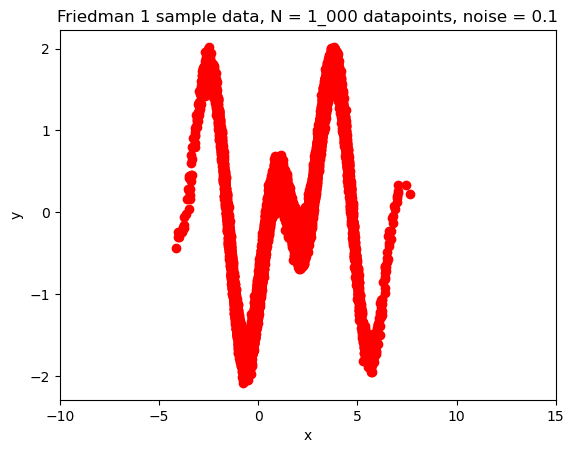

In [12]:
## Get data
mean = 1.5
stdev = 1.5
noise = 0.1

N_train = 50_000
X_train = torch.tensor(np.random.normal(loc=mean, scale=stdev, size=(N_train, 1)), dtype=torch.float32)
y = np.sin(2 * X_train) - np.cos(X_train)
y_train = torch.tensor(y + (noise * np.random.normal(size = (N_train, 1))), dtype=torch.float32).squeeze()

N_test = 1_000
X_test = torch.linspace(-10, 15, N_test).reshape(-1, 1)
y_test = np.sin(2 * X_test) - np.cos(X_test)

# TRAIN VAL TEST SPLIT
split = [0.80, 0.20]
train_idx = np.arange(0, int(split[0]*N_train))
val_idx = np.arange(int(split[0]*N_train), N_train)

train_dataset = TensorDataset(X_train[train_idx], y_train.unsqueeze(1)[train_idx])
val_dataset = TensorDataset(X_train[val_idx], y_train.unsqueeze(1)[val_idx])
test_dataset = TensorDataset(X_test, y_test)

print("DATALOADER FOR SNGP", X_train.shape, y_train.unsqueeze(1).shape)
print("TRAIN VAL TEST SPLIT:", X_train.shape, y_train.shape)

train_loader = DataLoader(train_dataset, batch_size=int(split[0]*N_train), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=int(split[1]*N_train), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=N_test, shuffle=True)


plt.plot(X_train[train_idx], y_train[train_idx], 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10, 15)
plt.title("Friedman 1 sample data, N = 1_000 datapoints, noise = 0.1")
plt.show()

In [74]:
## Training GP
gp = FullGPCholesky(lengthscale=1.0, outputscale=1.0, noise=0.2, learn_hyperparams=True)
losses = train_gp(gp, X_train, y_train, n_iterations=400, lr=0.01)
gp.fit(X_train, y_train)

Iter   0 | Loss: -525.585 | lengthscale: 1.010 | outputscale: 1.010 | noise: 0.198
Iter 100 | Loss: -857.260 | lengthscale: 1.251 | outputscale: 1.816 | noise: 0.099
Iter 200 | Loss: -857.436 | lengthscale: 1.270 | outputscale: 1.913 | noise: 0.098
Iter 300 | Loss: -857.422 | lengthscale: 1.269 | outputscale: 1.915 | noise: 0.098
Iter 399 | Loss: -857.398 | lengthscale: 1.270 | outputscale: 1.917 | noise: 0.098


/var/folders/v1/94zh7tfn1vgcxh44wvvc48f40000gn/T/ipykernel_49589/970423362.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(X_test.squeeze().detach().numpy(), y_test.detach().numpy(), 'k--', c="red", linewidth=1, label='True function')


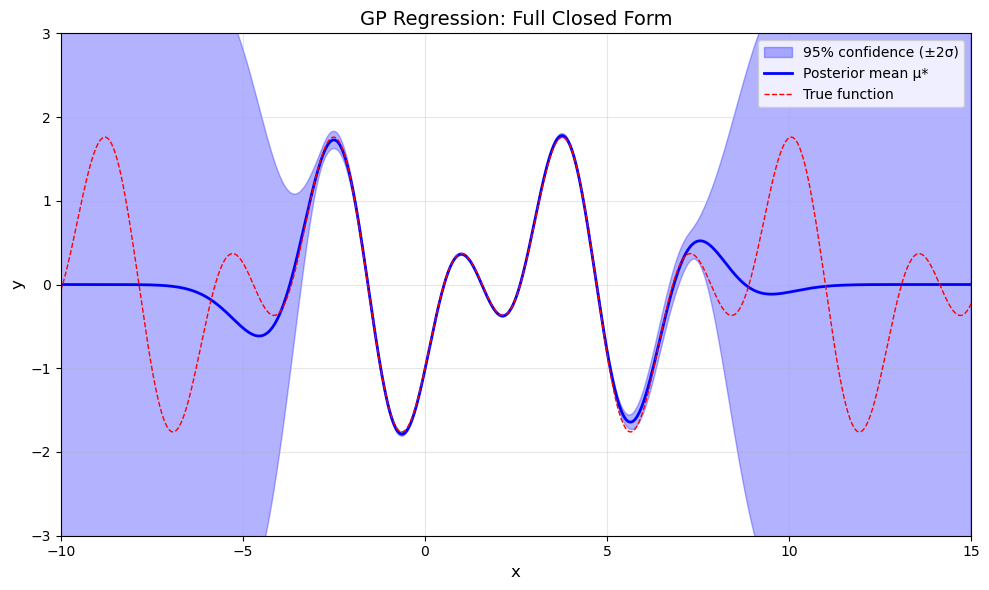

In [103]:
mean, var, cov = gp.predict(X_test)
std = torch.sqrt(var.clamp(min=1e-6))

# Sort X_test and get sorting indices
X_sorted, sort_idx = torch.sort(X_test.squeeze())
X_sorted = X_sorted.detach().numpy()

# Apply same sorting to predictions and test values
mean_sorted = mean[sort_idx].detach().numpy()
std_sorted = std[sort_idx].detach().numpy()
y_test_sorted = y_test[sort_idx].detach().numpy()

# Evaluate true function at sorted X values
y_true_sorted = torch.sin(torch.tensor(X_sorted)).numpy()  # or however you define y

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

ax1 = axes
ax1.fill_between(
    X_sorted,
    mean_sorted - 2*std_sorted,
    mean_sorted + 2*std_sorted,
    alpha=0.3, color='blue', label='95% confidence (±2σ)'
)
ax1.plot(X_sorted, mean_sorted, 'b-', linewidth=2, label='Posterior mean μ*')
ax1.plot(X_test.squeeze().detach().numpy(), y_test.detach().numpy(), 'k--', c="red", linewidth=1, label='True function')
#ax1.scatter(X_test.squeeze().detach().numpy(), y_test.detach().numpy(), 
            # c='red', s=100, zorder=5, label='Training data')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('GP Regression: Full Closed Form', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-10, 15)
ax1.set_ylim(-3, 3)

plt.tight_layout()
plt.savefig('full_gp_regression.png', dpi=600)

In [7]:
rank= 200
lengthscale = 1.2
outputscale = 2.0

sngp_model = RFFGP_Reg(in_features=1,
                       out_features=1,
                       rank = rank,
                       lengthscale= lengthscale,
                       outputscale= outputscale).to(device)
print(sngp_model)

RFFGP_Reg(
  (linear): Linear(in_features=200, out_features=1, bias=False)
)


In [8]:
trained_model, info = train_model(sngp_model, device, train_loader, val_loader, l2pen_mag=1.0,
                                  n_epochs=2000, lr=0.00001, do_early_stopping=True, 
                                  model_filename="results/models/sngp_best_model.pth")

 26%|██▌       | 523/2001 [02:57<08:21,  2.95it/s, tr_loss=458, tr_sqloss=458, tr_mse=0.0115, va_loss=tensor(114.6009), va_sqloss=115, va_mse=0.0115, batch_done=1]          


KeyboardInterrupt: 

In [9]:
trained_model.update_precision_from_loader(train_loader)
covariance = trained_model.invert_covariance()

/Users/shanewilliams/GradSchool/Fall2025/Statistical_Pattern_Recognition/gp_vs_sngp/sngp/model.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(covariance_RR, dtype=torch.float32).to(device)


/Users/shanewilliams/GradSchool/Fall2025/Statistical_Pattern_Recognition/gp_vs_sngp/sngp/model.py:57: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741562938389/work/aten/src/ATen/native/TensorShape.cpp:3729.)
  var_pred = features_R1.T @ covariance @ features_R1
/var/folders/v1/94zh7tfn1vgcxh44wvvc48f40000gn/T/ipykernel_53567/3814512987.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(X_sorted, y_test_sorted, 'k--', c="red", linewidth=1, label='True function')


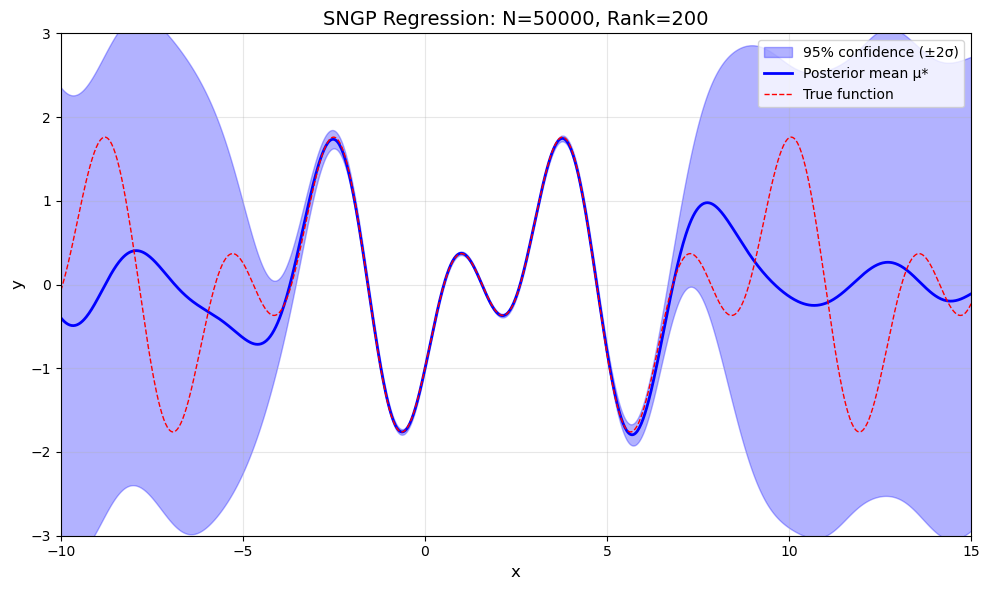

In [10]:
samples, mean, var = trained_model.predict(X_test.to(device), covariance=covariance, num_samples=20_000)
mean = mean.flatten()
var = torch.stack(var).squeeze()
std = torch.sqrt(var)

# Sort X_test and get sorting indices
X_sorted, sort_idx = torch.sort(X_test.squeeze())
X_sorted = X_sorted.detach().numpy()

# Apply same sorting to predictions and test values
mean_sorted = mean[sort_idx].detach().numpy()
std_sorted = std[sort_idx].detach().numpy()
y_test_sorted = y_test[sort_idx].detach().numpy()

# Evaluate true function at sorted X values
y_true_sorted = torch.sin(torch.tensor(X_sorted)).numpy()  # or however you define y

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

ax1 = axes
ax1.fill_between(
    X_sorted,
    mean_sorted - 2*std_sorted,
    mean_sorted + 2*std_sorted,
    alpha=0.3, color='blue', label='95% confidence (±2σ)'
)
ax1.plot(X_sorted, mean_sorted, 'b-', linewidth=2, label='Posterior mean μ*')
ax1.plot(X_sorted, y_test_sorted, 'k--', c="red", linewidth=1, label='True function')
#ax1.scatter(X_test.squeeze().detach().numpy(), y_test.detach().numpy(), 
            # c='red', s=100, zorder=5, label='Training data')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title(f'SNGP Regression: N={N_train}, Rank={rank}', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(min(X_sorted), max(X_sorted))
ax1.set_ylim(-3, 3)

plt.tight_layout()
plt.savefig('full_gp_regression.png', dpi=600)